In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

telemetry-simulator.csv


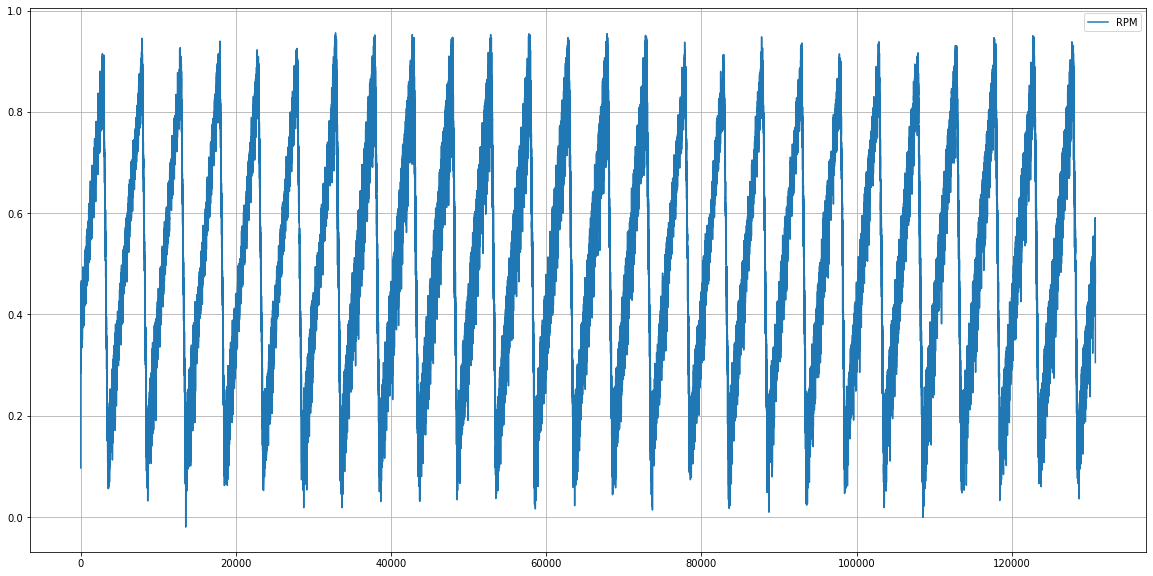

In [3]:
max_rpm = 16057

input_files = ["telemetry-simulator.csv"]
csvs = []
period = 5
for file in input_files:
    print(file)
    csv = pd.read_csv(file)
    csv["motor_rpm"] = np.convolve(csv["motor_rpm"], np.ones((period,)) / period, mode='same')
    csvs += [csv]
    
for csv in csvs:    
    plt.figure(figsize=(20, 10))
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["motor_rpm"] / max_rpm, label="RPM")
    plt.legend()
    plt.show()

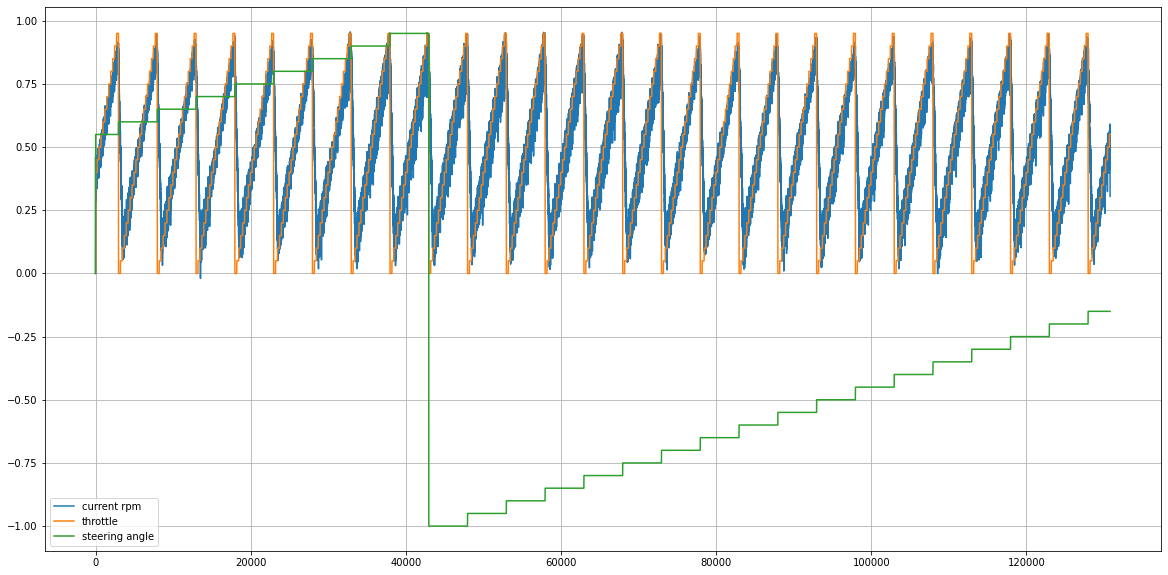

In [4]:
# I want the intput to be in the form of:
# (current RPM, throttle input, steering input, RPM change rate)

import numpy as np

data = np.array(np.zeros(4))

for csv in csvs:
    previous_rpm = 0
    for index, row in csv.iterrows():
        next_rpm = row["motor_rpm"] / max_rpm       
        previous_rpm = next_rpm
        
        record = [previous_rpm, row["throttle_input"], row["steering_angle_input"], next_rpm]
        
        data = np.vstack((data, record))

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:, 0], label="current rpm")
plt.plot(data[:, 1], label="throttle")
plt.plot(data[:, 2], label="steering angle")
plt.legend()
plt.show()

In [6]:
#np.random.shuffle(data)

training_portion = 0.8
split_point = int(len(data)*training_portion)
train = data[:split_point,:]
test = data[split_point:,:]

x_test = test[:, :-1]
y_test = test[:, -1]

x_train = train[:, :-1]
y_train = train[:, -1]

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(len(x_test[0]), activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'])

model.fit(x_train, y_train, epochs=50, use_multiprocessing=True)

model.evaluate(x_test, y_test)

Train on 11787 samples
Epoch 1/50
11787/11787 [==============================] - 2s 164us/sample - loss: 0.0623 - mean_absolute_error: 0.1829 - mean_squared_error: 0.0623

[0.03441112716825651, 0.13140559, 0.034411125]

In [12]:
predicted_rpm = []
rpm = 0
for row in data[:500]:
    rpm = float(model.predict([(rpm, row[1], row[2])])[0][0])
    predicted_rpm += [rpm]

NameError: name 'model' is not defined

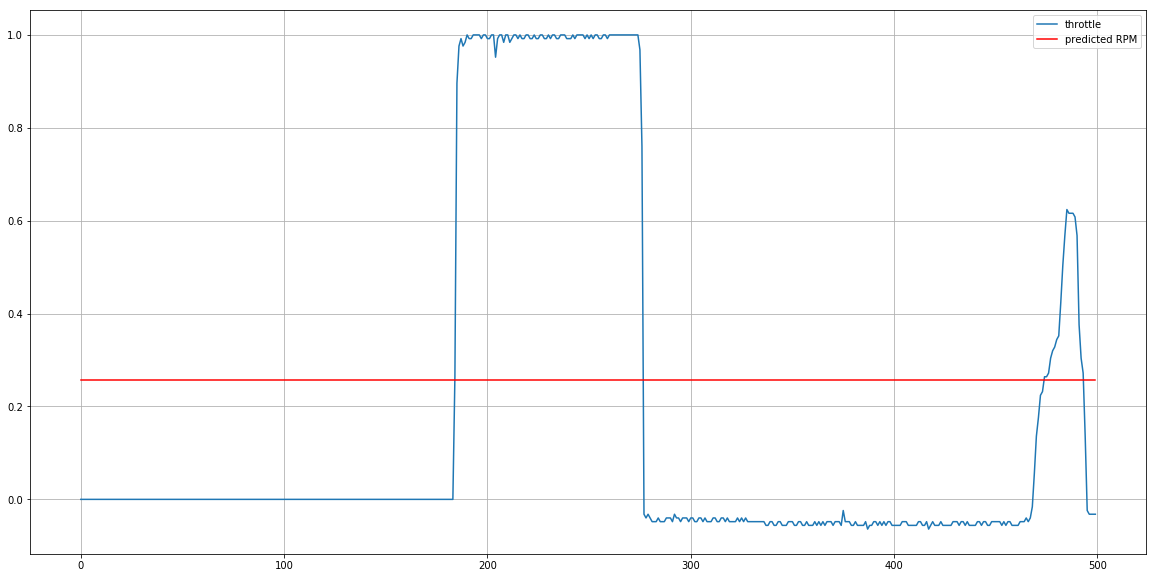

In [7]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:len(predicted_rpm), 1], label="throttle")
#plt.plot(data[:1000, 1], label="steering angle")
#plt.plot(data[:,-1], 'b', label="measured RPM")
plt.plot(predicted_rpm, 'r', label="predicted RPM")
plt.legend()
lt.show()

In [52]:
import neat
import random

def predict(net, offset, n):
    rpm = data[offset, 0]
    for row in data[offset:(offset + n)]:
        rpm = net.activate((rpm, row[1], row[2]))[0]
        yield rpm

def activate_for(net, offset, n):
    for row in data[offset:(offset + n)]:
        yield net.activate((row[0], row[1], row[2]))[0]
        
def calculate_error(net, offset, n):
    error_sq = 0
    prediction = activate_for(net, offset, n)
    ref = data[offset:(offset + n), 3]
    for (rpm, target_rpm) in zip(prediction, ref):
        error_sq += (rpm - target_rpm) ** 2
        
    return error_sq

def eval_genomes(genomes, config):
    n = 10
    k = 20
    for genome_id, genome in genomes:
        genome.fitness = 0
            
    for i in range(k):
        offset = random.randint(0, len(data) - n)
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            err = calculate_error(net, offset, n)
            genome.fitness -= err

config_file = "./evolution-config.ini"
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to N generations.
N = 200
evaluator = neat.parallel.ParallelEvaluator(8, eval_genomes)
winner = p.run(eval_genomes, N)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

# visualize.draw_net(config, winner, True, node_names=node_names)
# visualize.plot_stats(stats, ylog=False, view=True)
# visualize.plot_species(stats, view=True)



 ****** Running generation 0 ****** 

Population's average fitness: -66.56404 stdev: 59.29149
Best fitness: -2.08618 - size: (6, 20) - species 1 - id 638
Average adjusted fitness: 0.553
Mean genetic distance 1.155, standard deviation 0.194
Population of 1000 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0  1000    -66.6    0.553     0
Total extinctions: 0
Generation time: 13.353 sec

 ****** Running generation 1 ****** 

Population's average fitness: -42.03656 stdev: 29.03690
Best fitness: -3.32567 - size: (6, 19) - species 1 - id 1657
Average adjusted fitness: 0.627
Mean genetic distance 1.242, standard deviation 0.207
Population of 1000 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1  1000    -42.0    0.627     0
Total extinctions: 0
Generation time: 9.824 sec (11.589 average)

 ****** Running generation 2 ****** 

Population's average fitness: 

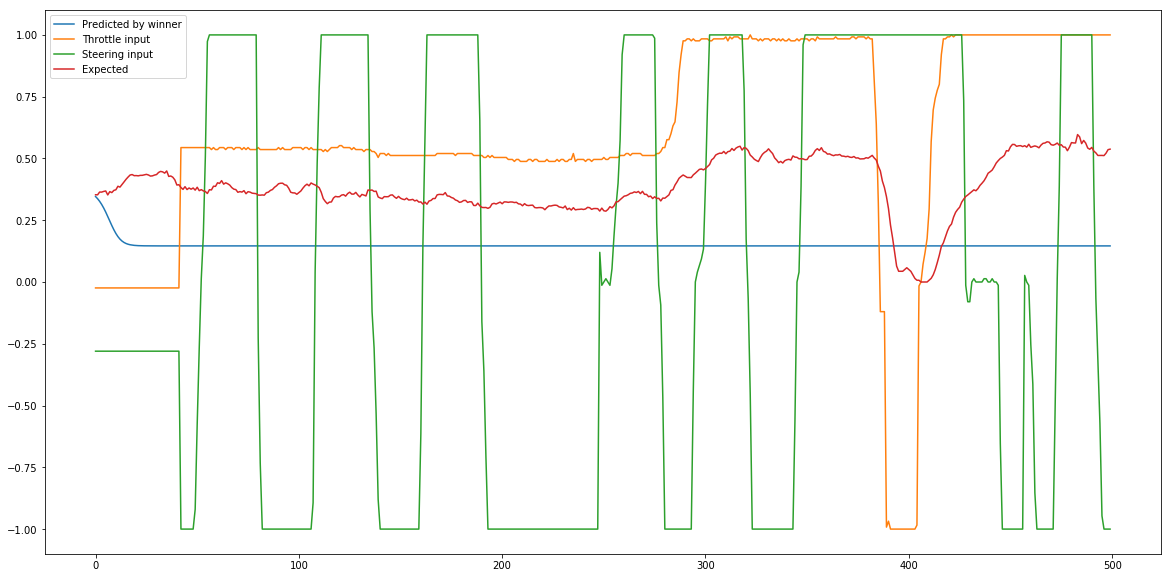

In [288]:
o = 2000
l = 500
predicted = list(predict(winner_net, o, l))
plt.figure(figsize=(20, 10))
plt.plot(predicted, label="Predicted by winner")
plt.plot(data[o:(o+l),1], label="Throttle input")
plt.plot(data[o:(o+l),2], label="Steering input")
plt.plot(data[o:(o+l),3], label="Expected")
plt.legend()
plt.show()

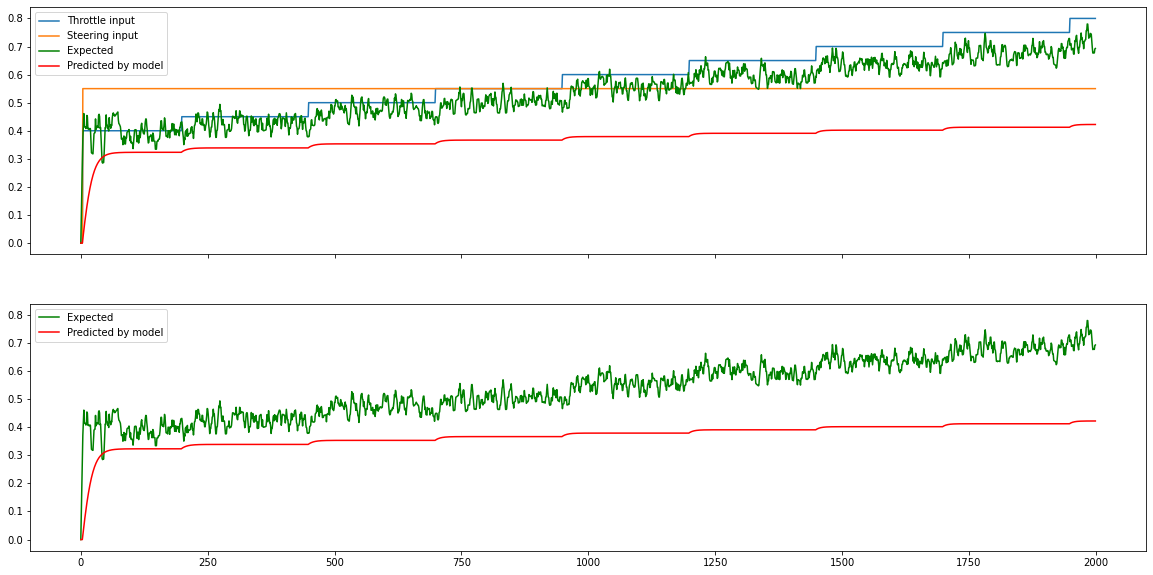

In [8]:
import math
max_rpm_normalized = 1.0

def torque(rpm, stall_torque):
    return stall_torque - (stall_torque / max_rpm_normalized) * rpm

def predict_torque(rpm, throttle, steering, x):
    drive_torque = torque(rpm, x[0]) * throttle
    load_torque = (rpm ** x[2]) * ((x[3] + x[4] * abs(steering)) ** x[5])

    return (drive_torque - load_torque) / x[1]

dt = 1./25.
steering_adjustment_step = 6.25 * dt
        
def predict_custom(offset, n, x):
    rpm = float(data[offset, 0])
    for row in data[offset:(offset + n)]:   
        motor_rpm_acc = predict_torque(rpm, row[1], row[2], x)        
        rpm = max(0, rpm + motor_rpm_acc * dt)
        yield rpm
        
o = 0
l = 2000
x = [800.0, 800.0, 2, 10.0, 5.0, 3.0]
predicted = np.array(list(predict_custom(o, l, x)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g', label="Expected")
ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g', label="Expected")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()
plt.show()


In [16]:
from scipy.optimize import minimize

def err(x):
    err = 0
    offset = 0
    for csv in csvs:
        predicted = predict_custom(offset, len(csv), x)
        offset += len(csv)
        for (pred, ref) in zip(predicted, data):
            err += (pred - ref[3]) ** 2
        return err

x0 = [800.0, 800.0, 2, 2.0, 2.0, 3.0]
bnds = ((0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100)) # positive numbers
res = minimize(err, x0, method='SLSQP', bounds=bnds).x

print(res)


[1.34766035e+01 9.85689204e+01 3.04029250e-01 2.97547762e+00
 3.53239664e-02 1.07792477e+00]


[6.82205434e-01 4.98973515e+00 3.04042420e-01 1.14233622e-01
 1.75619175e-03 8.33364936e-01]


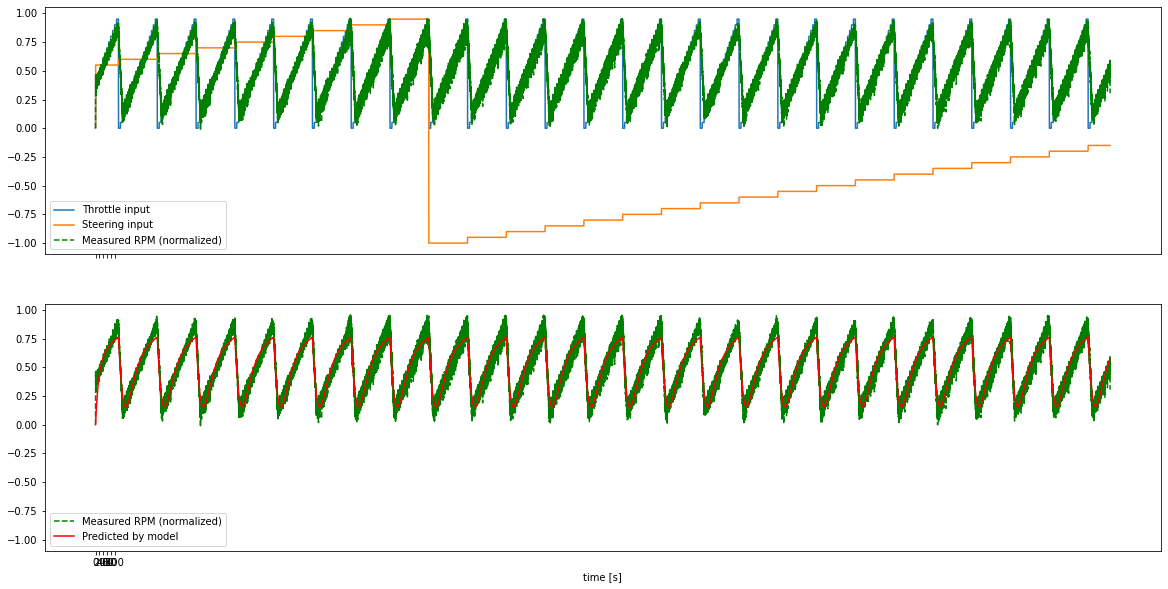

In [15]:
l = len(data)
o = 0

print(res)

# for csv in csvs:
#     o += l
#     l = len(csv)
predicted = np.array(list(predict_custom(o, l, res)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
#ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()

plt.xlabel("time [s]")
plt.xticks([0, 500, 1000, 1500, 2000, 2500], [0, 20, 40, 60, 80, 100])

plt.show()
# plt.savefig("fit_{}.pdf".format(o));